In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab\ Notebooks/cours_python/FSCI2610/projet/Finale

/content/drive/MyDrive/Colab Notebooks/cours_python/FSCI2610/projet/Finale


In [ ]:
#optionnel: !pip install --upgrade pip setuptools wheel

In [ ]:
!pip install praat-parselmouth

In [ ]:
import librosa
import numpy as np
import parselmouth #Praat wrapper
from scipy.stats import variation

# Load the audio file
def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

# Compute MFCC features
def compute_mfcc(y, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc

# Compute F0 (fundamental frequency) using Parselmouth (Praat wrapper)
def compute_f0(file_path):
    sound = parselmouth.Sound(file_path)
    pitch = sound.to_pitch()
    f0 = pitch.selected_array['frequency']
    f0 = f0[f0 > 0]  # Remove zero or negative values
    return f0

# Compute Jitter (F0 variation)
def compute_jitter(f0):
    # Jitter is the variation in F0, measured as the relative standard deviation
    jitter = variation(f0) if len(f0) > 1 else 0
    return jitter

# Compute Shimmer (Amplitude variation)
def compute_shimmer(y):
    # Calculate short-term energy (amplitude variation)
    frame_length = 2048
    hop_length = 512
    energy = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)

    # Compute the variation of energy
    shimmer = variation(energy.flatten()) if len(energy.flatten()) > 1 else 0
    return shimmer

# Compute HNR (Harmonics-to-Noise Ratio)
def compute_hnr(file_path):
    sound = parselmouth.Sound(file_path)
    pitch = sound.to_pitch()
    harmonicity = sound.to_harmonicity()

    # HNR is the ratio of harmonic to noise components
    hnr = harmonicity.values.T
    return np.mean(hnr[hnr > 0])  # Only consider positive HNR values

# Main function to compute all features
def compute_voice_features(file_path):
    # Load the audio file
    y, sr = load_audio(file_path)

    # Compute MFCCs
    mfcc = compute_mfcc(y, sr)

    # Compute F0
    f0 = compute_f0(file_path)

    # Compute Jitter
    jitter = compute_jitter(f0)

    # Compute Shimmer
    shimmer = compute_shimmer(y)

    # Compute HNR
    hnr = compute_hnr(file_path)

    # Results
    features = {
        'MFCC': mfcc,
        'f0': f0,
        'Jitter': jitter,
        'Shimmer': shimmer,
        'HNR': hnr
    }

    return features

file_path = './voice_samples/Normal_Voice.wav'
features = compute_voice_features(file_path)

# Print features
print("MFCCs:", features['MFCC'].shape)
print("Means f0 (Fundamental Frequency):", np.mean(features['f0']))
print("Jitter:", features['Jitter'])
print("Shimmer:", features['Shimmer'])
print("HNR:", features['HNR'])


MFCCs: (13, 2712)
Means f0 (Fundamental Frequency): 212.45936758708945
Jitter: 0.2010853914661789
Shimmer: 0.8738553
HNR: 14.17612320806539


Formant frequencies:
 [[7.3285220e-04 8.3032066e+01 1.3936732e+02 ... 7.4787552e+01
  7.8670410e+01 7.1553932e+01]
 [7.3285220e-04 8.3032066e+01 1.3936732e+02 ... 7.4787552e+01
  7.8670410e+01 7.1553932e+01]
 [7.3285220e-04 8.3032066e+01 1.3936732e+02 ... 7.4787552e+01
  7.8670410e+01 7.1553932e+01]
 ...
 [7.3285220e-04 8.3032066e+01 1.3936732e+02 ... 7.4787552e+01
  7.8670410e+01 7.1553932e+01]
 [7.3285220e-04 8.3032066e+01 1.3936732e+02 ... 7.4787552e+01
  7.8670410e+01 7.1553932e+01]
 [7.3285220e-04 8.3032066e+01 1.3936732e+02 ... 7.4787552e+01
  7.8670410e+01 7.1553932e+01]]


Peaks indexes are:
 [ 1  3  5  7 11]


Means Peak values are:
 [102.0045394897461, 21.143102645874023, 15.463977813720703, 5.920587062835693, 2.55136775970459]


Formant Dictionary is:
 {'f0': 102.0045394897461, 'F1': 2.55136775970459, 'F2': 5.920587062835693, 'F3': 15.463977813720703, 'F4': 21.143102645874023} 



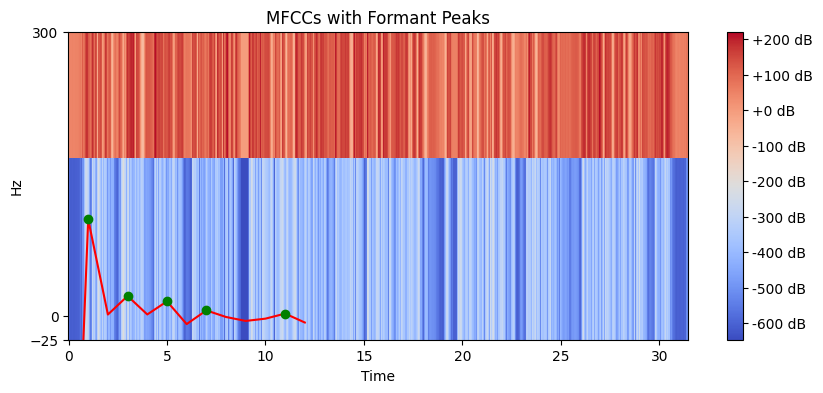

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the audio file
y, sr = librosa.load(file_path, sr=None)

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Find peaks in MFCCs
peaks, _ = find_peaks(mfccs.mean(axis=1))  # Find peaks across all MFCC coefficients

# Map peak indices to frequencies
# Reshape the MFCC data to have 2 dimensions before applying mfcc_to_mel
formant_frequencies = librosa.mel_to_hz(librosa.feature.inverse.mfcc_to_mel(mfccs.T[peaks][:, np.newaxis].mean(axis=0)))
# The [:, np.newaxis] part adds an extra dimension to the selected MFCCs, ensuring that it is a 2D array.

peak_values = [float(np.mean(mfccs[1])),float(np.mean(mfccs[3])),float(np.mean(mfccs[5])), float(np.mean(mfccs[7])), float(np.mean(mfccs[11]))]

# Print formant frequencies
print("Formant frequencies:\n", formant_frequencies)

print("\n\nPeaks indexes are:\n", peaks)
print("\n\nMeans Peak values are:\n", peak_values)

#The highest frequency is f0, and the next four lowest frequencies are F1-F4
keys=["f0", "F1", "F2", "F3", "F4"]

peak_values = [peak_values[0]]+(list(sorted(peak_values[1:])))
formant_dict = dict(zip(keys, peak_values))
print("\n\nFormant Dictionary is:\n", formant_dict, "\n")

# Visualize the MFCCs and peaks
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis='mel')
plt.ylim(-25,300)
plt.plot(np.arange(len(mfccs.mean(axis=1))), mfccs.mean(axis=1), color='red')
plt.plot(peaks, mfccs.mean(axis=1)[peaks], marker='o', color='green', linestyle='None')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs with Formant Peaks')
plt.show()

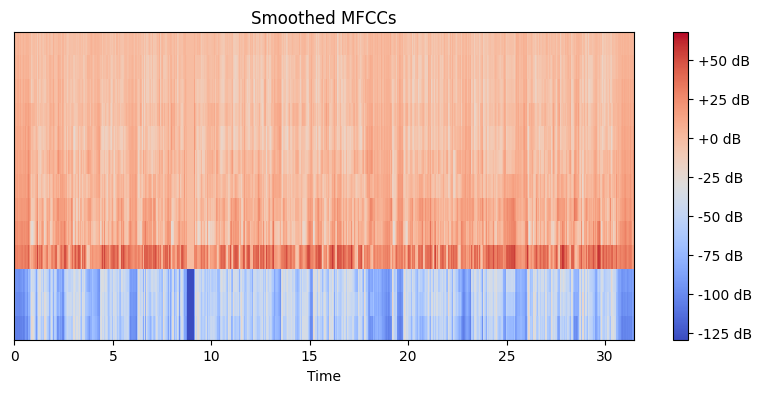

In [ ]:
# Example: Cepstral Smoothing (very basic)
# Apply smoothing along the desired axis (e.g., axis=0 for time)
smoothed_mfcc = np.apply_along_axis(lambda m: np.convolve(m, np.ones(5), 'same') / 5, axis=0, arr=mfccs)

# Example: Visualize Smoothed MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(smoothed_mfcc, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Smoothed MFCCs')
plt.show()

y length is: 2712

Cluster Labels: [1 2 2 ... 1 1 1]


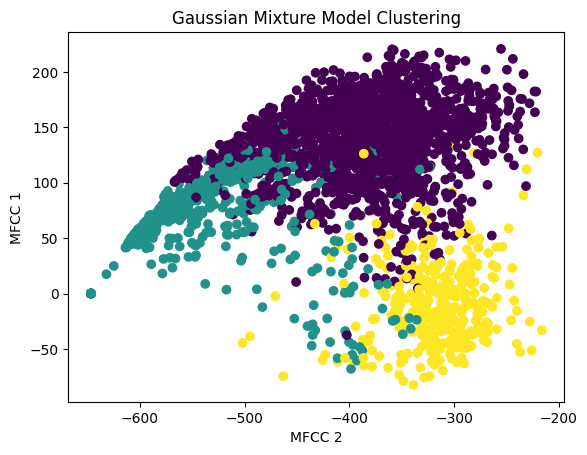

In [ ]:
#Tentative d'estimer les 'formants' F1, F2, F3, F4 en utilisant l'approche GMM
#tel que proposé par l'article suivante:

#https://www.researchgate.net/journal/Acoustics-Speech-and-Signal-Processing-1988-ICASSP-88-1988-International-Conference-on-1520-6149?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6InB1YmxpY2F0aW9uIiwicGFnZSI6InB1YmxpY2F0aW9uIn19

from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Use MFCCs for clustering
y = mfccs.T  # Transpose mfccs to have shape (n_samples, n_features)
print("y length is:", len(y))

# Fit GMM with a reduced number of components and increased regularization
gmm = GaussianMixture(n_components=3, covariance_type="tied", reg_covar=1e-2)
gmm.fit(y)

# Predict the labels (cluster assignments)
labels = gmm.predict(y)

print("\nCluster Labels:", labels)

# Plot the results using the first two MFCCs as an example
plt.scatter(y[:, 0], y[:, 1], c=labels, cmap='viridis')
plt.ylabel('MFCC 1')
plt.xlabel('MFCC 2')
plt.title('Gaussian Mixture Model Clustering')
plt.show()

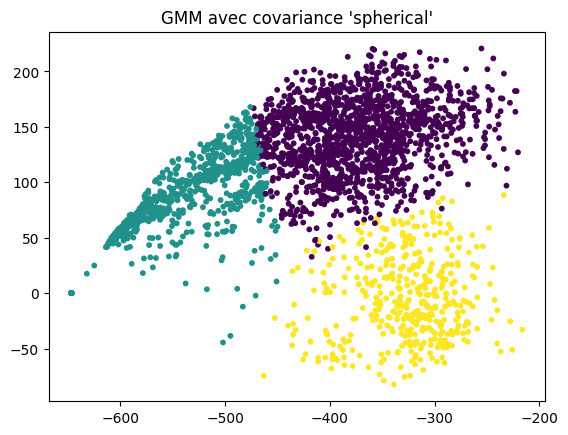

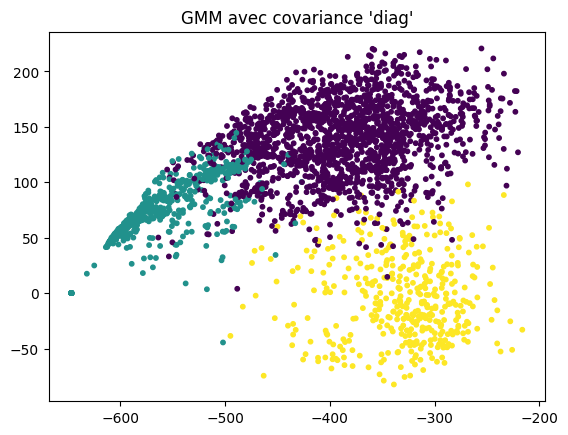

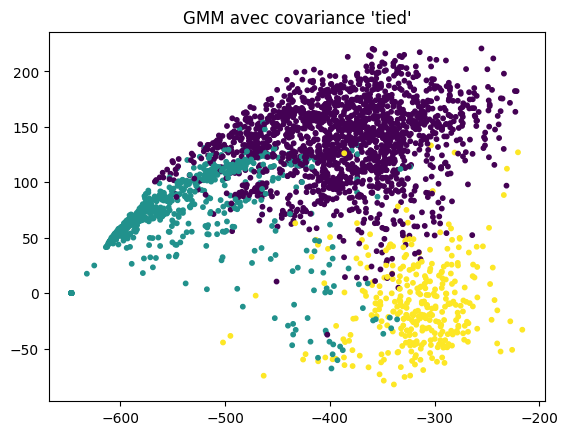

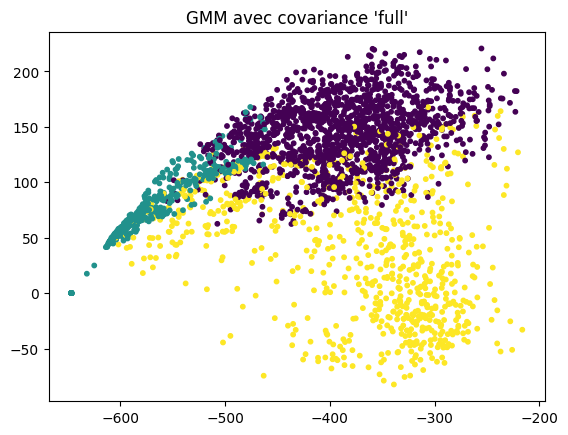

In [ ]:
from sklearn.mixture import GaussianMixture

for cov_type in ["spherical", "diag", "tied", "full"]:
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type, random_state=42)
    labels = gmm.fit_predict(y)

    plt.scatter(y[:, 0], y[:, 1], c=labels, cmap="viridis", s=10)
    plt.title(f"GMM avec covariance '{cov_type}'")
    plt.show()


Type de covariance: spherical, AIC: 327194.63233454386, BIC: 327454.4717671025
Type de covariance: diag, AIC: 302977.8621312892, BIC: 303450.297463214
Type de covariance: tied, AIC: 295832.17721965455, BIC: 296611.6955173305
Type de covariance: full, AIC: 274094.9304697684, BIC: 275949.23914757336

Meilleur type de covariance en se basant sur AIC: 'full'

Meilleur type de covariance en se basant sur BIC: 'full'


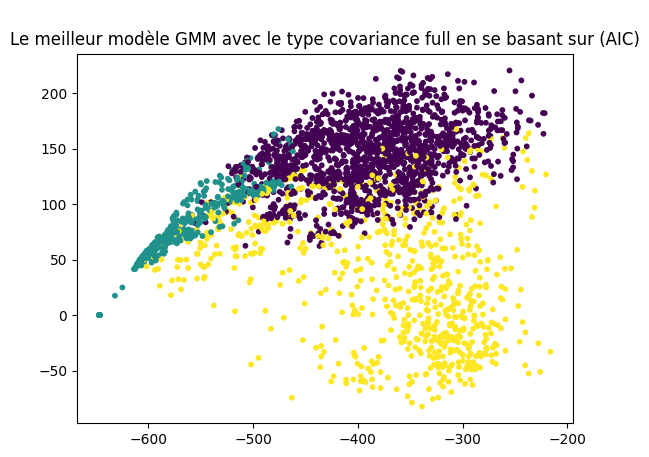

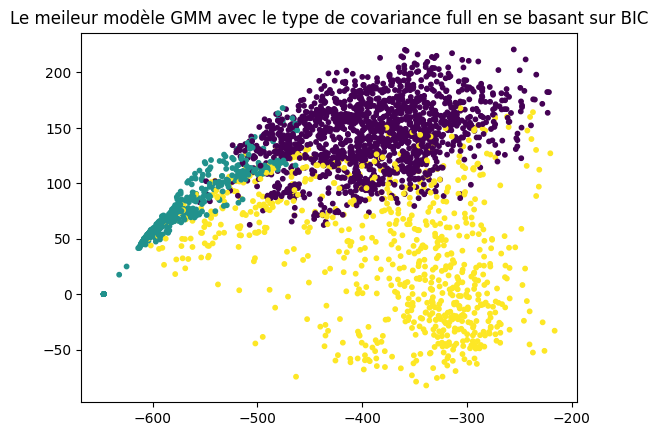

In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

#X est normalisé avec StandardScaler plus haut.

best_gmm = None
best_aic = float('inf')
best_bic = float('inf')
best_cov_type_aic = ""
best_cov_type_bic = ""

covariance_types = ["spherical", "diag", "tied", "full"]

for cov_type in covariance_types:
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type, random_state=42)
    gmm.fit(y)

    aic = gmm.aic(y)
    bic = gmm.bic(y)

    print(f"Type de covariance: {cov_type}, AIC: {aic}, BIC: {bic}")

    if aic < best_aic:
        best_aic = aic
        best_cov_type_aic = cov_type

    if bic < best_bic:
        best_bic = bic
        best_cov_type_bic = cov_type

print(f"\nMeilleur type de covariance en se basant sur AIC: '{best_cov_type_aic}'")
print(f"\nMeilleur type de covariance en se basant sur BIC: '{best_cov_type_bic}'")

# Visualiser les meilleures modèles baser sur AIC et BIC, respectivement.
best_gmm_aic = GaussianMixture(n_components=3, covariance_type=best_cov_type_aic, random_state=42)
labels_aic = best_gmm_aic.fit_predict(y)

best_gmm_bic = GaussianMixture(n_components=3, covariance_type=best_cov_type_bic, random_state=42)
labels_bic = best_gmm_bic.fit_predict(y)

plt.scatter(y[:, 0], y[:, 1], c=labels_aic, cmap="viridis", s=10)
plt.title(f"\nLe meilleur modèle GMM avec le type covariance {best_cov_type_aic} en se basant sur (AIC)")
plt.show()

plt.scatter(y[:, 0], y[:, 1], c=labels_bic, cmap="viridis", s=10)
plt.title(f"Le meileur modèle GMM avec le type de covariance {best_cov_type_bic} en se basant sur BIC")
plt.show()



In [ ]:
!pip install formantfeatures

In [ ]:
#Pour des raisons de court avec le temps, j'ai opté d'abandonner la librairie
#'formantfeatures'

import formantfeatures as ff

formants_features, frame_count, signal_length, trimmed_length = ff.Extract_wav_file_formants(file_path, window_length, window_step, emphasize_ratio, norm=0, f0_min=f0_min, f0_max=f0_max, max_frames=max_frames, formants=max_formants)

In [ ]:
https://www.researchgate.net/journal/Acoustics-Speech-and-Signal-Processing-1988-ICASSP-88-1988-International-Conference-on-1520-6149?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6InB1YmxpY2F0aW9uIiwicGFnZSI6InB1YmxpY2F0aW9uIn19

SyntaxError: invalid syntax (<ipython-input-14-63297f92978c>, line 1)